# Lab 07: Nearest neighbors

In this lab, we will apply nearest neighbors classification to the Endometrium vs. Uterus cancer data. For documentation, see:
* http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification; and 
* http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier


Let us start by setting up our environment, loading the data, and setting up our cross-validation.

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load the data as in the previous labs. We will use `small_Endometrium_Uterus.csv` for this lab.

(183, 3000)


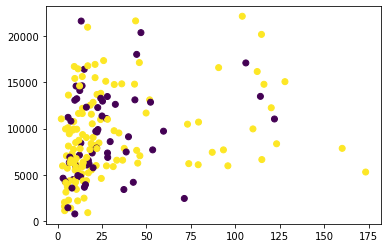

In [2]:
from sklearn import preprocessing

# load the endometrium vs. uterus tumor data
endometrium_data = pd.read_csv('data/small_Endometrium_Uterus.csv', sep=",")  # load data
endometrium_data.head(n=5)  # adjust n to view more data

# Create the design matrix and target vector
X_clf = endometrium_data.drop(['ID_REF', 'Tissue'], axis=1).values
y_clf = pd.get_dummies(endometrium_data['Tissue']).values[:,1]

print(X_clf.shape)
plt.scatter(X_clf[:,0], X_clf[:,1], c=y_clf)

Recall functions we had used to create cross validation folds in the previous labs. Redefine them here. 

*Note* : We shall call this *m*-fold cross validation, unlike *k*-fold, which we used in our previous labs, to distinguish it from *k*-nearest neighbors classification. This emphasizes that the two parameters are indeed different from each other.

In [3]:
from sklearn import model_selection

def stratifiedMFolds(y, num_folds):
    kf = model_selection.StratifiedKFold(n_splits=num_folds)
    folds_ = [(tr, te) for (tr, te) in kf.split(np.zeros(y.size), y)]
    return folds_

Now create 10 cross validate folds on the data. 

In [4]:
cv_folds = stratifiedMFolds(y_clf, 10)

Import the previously written cross validation function.

In [5]:
# let's redefine the cross-validation procedure with standardization
from sklearn import preprocessing
def cross_validate(design_matrix, labels, regressor, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
    Use a scaler to scale the features to mean 0, standard deviation 1.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  Regressor instance; must have the following methods:
        - fit(X, y) to train the regressor on the data X, y
        - predict_proba(X) to apply the trained regressor to the data X and return predicted values
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    
    n_classes = np.unique(labels).size
    pred = np.zeros((labels.shape[0], n_classes))
    for tr, te in cv_folds:
        scaler = preprocessing.StandardScaler()
        Xtr = scaler.fit_transform(design_matrix[tr,:])
        ytr =  labels[tr]
        Xte = scaler.transform(design_matrix[te,:])
        regressor.fit(Xtr, ytr)
        pred[te, :] = regressor.predict_proba(Xte)
    return pred

# 1. *k*-Nearest Neighbours Classifier

A k-neighbours classifier can be initialised as `knn_clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)`

Cross validate 20 *k*-NN classifiers on the loaded datset using `cross_validate`. 

In [6]:
from sklearn import neighbors
from sklearn import metrics

aurocs_clf = []
# Create a range of values of k. We will use this throughout the lab.
k_range    = range(1,40,2) 

for k in k_range:
    clf    = neighbors.KNeighborsClassifier(n_neighbors=k)
    y_pred = cross_validate(X_clf, y_clf, clf, cv_folds)
    
    fpr, tpr, thresholdss = metrics.roc_curve(y_clf, y_pred[:,1])
    aurocs_clf.append(metrics.auc(fpr,tpr))

__Question:__ Plot the AUC as a function of the number of nearest neighbours chosen.

Text(0.5, 1.0, 'Nearest neighbours classification - cross validated AUC.')

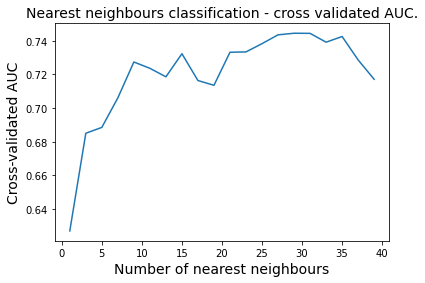

In [7]:
plt.plot(list(range(1,40,2)), aurocs_clf)
plt.xlabel('Number of nearest neighbours', fontsize=14)
plt.ylabel('Cross-validated AUC', fontsize=14)
plt.title('Nearest neighbours classification - cross validated AUC.', fontsize=14)

**Question.** Find the best value for the parameter `n_neighbors` by finding the one that gives the maximum value of AUC.

Let us now use `sklearn.model_selection.GridSearchCV` do to the same. The parameter to be cross-validated is the number of nearest neighbours to choose. Use an appropriate list to feed to `GridSearchCV` to find the best value for the nearest neighbours parameter.

In [8]:
from sklearn import model_selection
from sklearn import metrics

classifier = neighbors.KNeighborsClassifier()

param_grid = {'n_neighbors': k_range}
clf_knn_opt = model_selection.GridSearchCV(classifier,  
                                           param_grid=param_grid, 
                                           cv=cv_folds,
                                          scoring='roc_auc')
clf_knn_opt.fit(X_clf, y_clf)

GridSearchCV(cv=[(array([ 19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12...
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164]),
                  array([165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182]))],
             estima

__Question:__ What is now the optimal parameter?

In [9]:
# Find the best parameter
clf_knn_opt.best_params_

{'n_neighbors': 25}

Try choosing different scoring metrics for GridSearchCV, and see how the result changes. You can find scoring metrics [here](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

Now compare the performance of the *k*-nearest neighbours classifier with logistic regularisation (both, non-regularised, and regularised).

In [10]:
from sklearn import linear_model

clf_logreg_l2 = linear_model.LogisticRegression()
logreg_params = {'C':[1e-3, 1e-2, 1e-1, 1., 1e2]}
                
clf_logreg_opt = model_selection.GridSearchCV(clf_logreg_l2, 
                                              param_grid=logreg_params, 
                                              cv=cv_folds,
                                              scoring='accuracy')
clf_logreg_opt.fit(X_clf, y_clf)
ypred_clf_logreg_opt = cross_validate(X_clf, y_clf, 
                                      clf_logreg_opt.best_estimator_, 
                                      cv_folds)
fpr_clf_logreg_opt, tpr_clf_logreg_opt, thresh = metrics.roc_curve(y_clf, 
                                                                   ypred_clf_logreg_opt[:,1])

/home/wbader/miniconda3/envs/tp-ml/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/wbader/miniconda3/envs/tp-ml/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

In [11]:
clf_logreg = linear_model.LogisticRegression(C=1e12)

ypred_clf_logreg = cross_validate(X_clf, y_clf, 
                                  clf_logreg, 
                                  cv_folds)
fpr_clf_logreg, tpr_clf_logreg, thresh = metrics.roc_curve(y_clf, 
                                                           ypred_clf_logreg[:, 1])

In [12]:
ypred_clf_knn_opt = cross_validate(X_clf, y_clf, clf_knn_opt.best_estimator_, cv_folds)
fpr_clf_knn_opt, tpr_clf_knn_opt, thresh = metrics.roc_curve(y_clf, ypred_clf_knn_opt[:, 1])

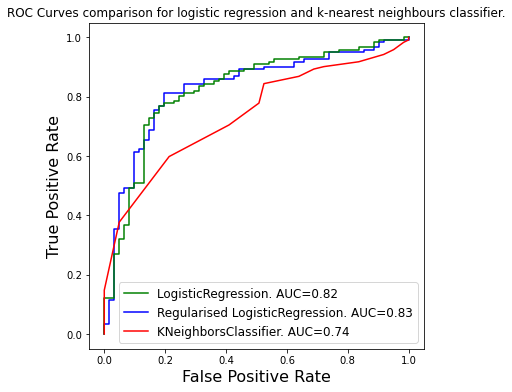

In [13]:
plt.figure(figsize=(6, 6))

logreg_l2_h,  = plt.plot(fpr_clf_logreg_opt, tpr_clf_logreg_opt, 'b-')
logreg_h,     = plt.plot(fpr_clf_logreg, tpr_clf_logreg, 'g-')
knn_h,        = plt.plot(fpr_clf_knn_opt, tpr_clf_knn_opt, 'r-')
logreg_l2_auc = metrics.auc(fpr_clf_logreg_opt, tpr_clf_logreg_opt)
logreg_auc    = metrics.auc(fpr_clf_logreg, tpr_clf_logreg)
knn_auc       = metrics.auc(fpr_clf_knn_opt, tpr_clf_knn_opt)

logreg_legend    = 'LogisticRegression. AUC=%.2f' %(logreg_auc)
logreg_l2_legend = 'Regularised LogisticRegression. AUC=%.2f' %(logreg_l2_auc)
knn_legend       = 'KNeighborsClassifier. AUC=%.2f' %(knn_auc)
plt.legend([logreg_h, logreg_l2_h, knn_h], 
           [logreg_legend, logreg_l2_legend, knn_legend], fontsize=12)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curves comparison for logistic regression and k-nearest neighbours classifier.')
plt.show()

### Setting the distance metric
__Question__ You will notice that *k*-nearest neighbours classifiers measure distances between points to determine similarity. By default, we use the Euclidean distance metric. Often, using other distance metrics can prove to be helpful. Try to change the distance metric used here by passing it as an argument to the declaration of the classifier. 

In [14]:
classifiers = {}            
y_preds     = {}            
# Fix a set of distance metrics to use
d_metrics = ["manhattan", "chebyshev"]
aurocs    = {}      

for m in d_metrics:
    aurocs[m] = []          
    for k in k_range: 
        classifiers[m] = neighbors.KNeighborsClassifier(n_neighbors=k, metric=m)
        y_preds[m]     = cross_validate(X_clf, y_clf, classifiers[m], cv_folds)
    
        fpr, tpr, thresholds = metrics.roc_curve(y_clf, y_preds[m][:,1])
        auc                  = metrics.auc(fpr, tpr)
        aurocs[m].append(auc)     
        
        print ('Metric = %-12s | k = %3d | AUC = %.3f.' %(m, k, aurocs[m][-1]))

Metric = manhattan    | k =   1 | AUC = 0.594.
Metric = manhattan    | k =   3 | AUC = 0.690.
Metric = manhattan    | k =   5 | AUC = 0.676.
Metric = manhattan    | k =   7 | AUC = 0.710.
Metric = manhattan    | k =   9 | AUC = 0.730.
Metric = manhattan    | k =  11 | AUC = 0.702.
Metric = manhattan    | k =  13 | AUC = 0.718.
Metric = manhattan    | k =  15 | AUC = 0.699.
Metric = manhattan    | k =  17 | AUC = 0.715.
Metric = manhattan    | k =  19 | AUC = 0.743.
Metric = manhattan    | k =  21 | AUC = 0.752.
Metric = manhattan    | k =  23 | AUC = 0.747.
Metric = manhattan    | k =  25 | AUC = 0.757.
Metric = manhattan    | k =  27 | AUC = 0.774.
Metric = manhattan    | k =  29 | AUC = 0.782.
Metric = manhattan    | k =  31 | AUC = 0.786.
Metric = manhattan    | k =  33 | AUC = 0.768.
Metric = manhattan    | k =  35 | AUC = 0.770.
Metric = manhattan    | k =  37 | AUC = 0.766.
Metric = manhattan    | k =  39 | AUC = 0.761.
Metric = chebyshev    | k =   1 | AUC = 0.504.
Metric = cheb

Let us now plot ROC curves for all the metrics together.

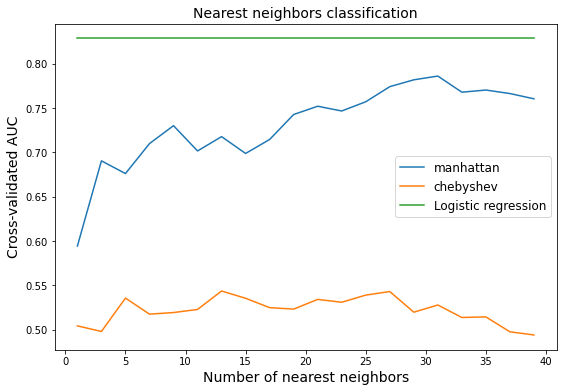

In [15]:
f = plt.figure(figsize=(9, 6))

for i in range(len(d_metrics)):              
    plt.plot(k_range, aurocs[d_metrics[i]])

plt.plot(k_range, [logreg_l2_auc for kval in k_range])    
    
plt.xlabel('Number of nearest neighbors', fontsize=14)
plt.ylabel('Cross-validated AUC', fontsize=14)
plt.title('Nearest neighbors classification', fontsize=14)

legends = [m for m in d_metrics]
legends.append('Logistic regression')
plt.legend(legends, fontsize=12)